<a href="https://colab.research.google.com/github/rbouftini/CSC4352-Portfolio/blob/main/TimeSeriesTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Time Series Modeling for Store Sales
In this analysis , our goal is to build a time series model for sales of a store


In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
drive.mount('/content/drive')
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


The first step is to transform the order date to a date object to facilitate manipulating the date

In [ ]:
df['Order Date']= pd.to_datetime(df['Order Date'],format= "%d/%m/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

We notice that the dates of the observations of sales are somewhat daily, but not everytime. This is expected because a store not necessarly will sell an item each day and also because of days off. This is important for our time series analysis because it requires measurements to be held at a fixed interval, therefore changing the period is necessary.


In [ ]:
df['Order Date'].sort_values().head(30)

7980   2015-01-03
741    2015-01-04
740    2015-01-04
739    2015-01-04
1759   2015-01-05
7478   2015-01-06
7477   2015-01-06
5327   2015-01-06
7474   2015-01-06
7480   2015-01-06
7475   2015-01-06
7180   2015-01-06
7476   2015-01-06
7479   2015-01-06
7661   2015-01-07
7660   2015-01-07
593    2015-01-09
592    2015-01-09
866    2015-01-10
865    2015-01-10
716    2015-01-11
763    2015-01-13
764    2015-01-13
765    2015-01-13
766    2015-01-13
767    2015-01-13
9629   2015-01-13
9628   2015-01-13
2978   2015-01-13
4937   2015-01-13
Name: Order Date, dtype: datetime64[ns]

Times series modeling require that observations are recorded in regular interval times. We will therefore based our anaylsis on the aggragation of total sales of each month.

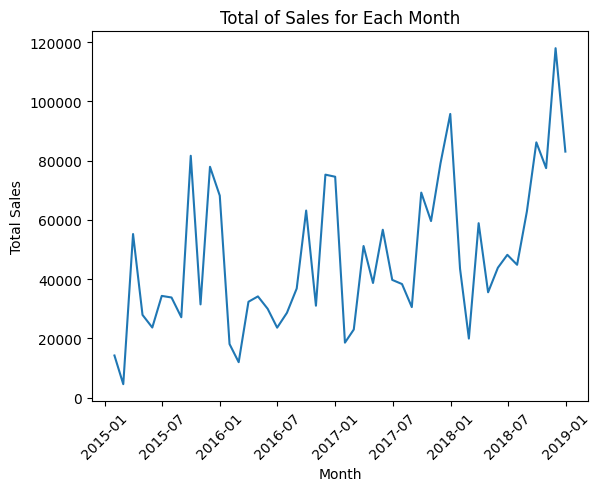

In [ ]:
sales = df.groupby(pd.Grouper(key='Order Date',freq='M')).sum()['Sales']
sales = sales.sort_index()
sns.lineplot(x=sales.index,y=sales.values)
plt.xticks(rotation=45)
plt.title("Total of Sales for Each Month")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

Properties of the series:
-There is no explicit trend in the sales where the average sales appears to be constant across different periods which might suggest stationarity of the series, however, in the last year there is an increasing trend in the sales.
-As expected for sales of a store, there is an increase in sales during each holidays period at the end of the year, which may suggest seasonality of the series and then no stationarity.

To test the stationarity of the series and the constant statistical properties of the series needed for our modeling, it is common in the litterature to perform adfuller test for stationarity of time series.


In [ ]:
adf_result = adfuller(sales.values)
test_statistic, p_value, _, _, _, _ = adf_result
print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')

# interpret the results
if p_value <= 0.05:
	print('Reject the null hypothesis: The time series is stationary.')
else:
	print('Fail to reject the null hypothesis: The time series is non-stationary.')

Test Statistic: -4.416136761430769
P-value: 0.00027791039276670623
Reject the null hypothesis: The time series is stationary.


Surprisingly, the p-value is very small and we can reject the null hypothesis that the series is non-stationary.

The are two importants features studied for time series are the autocorrelation of an observation with previous values and the partial autocorrelation that does not take into consideration the correlation between the previous values. We can plot two graphs that show us those two features to understand the properties of the series and help us choose the best model.

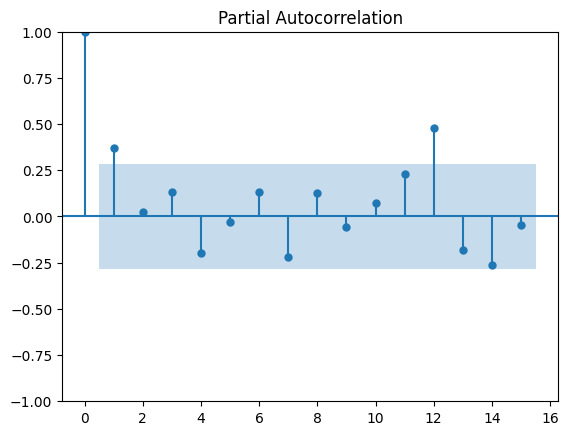

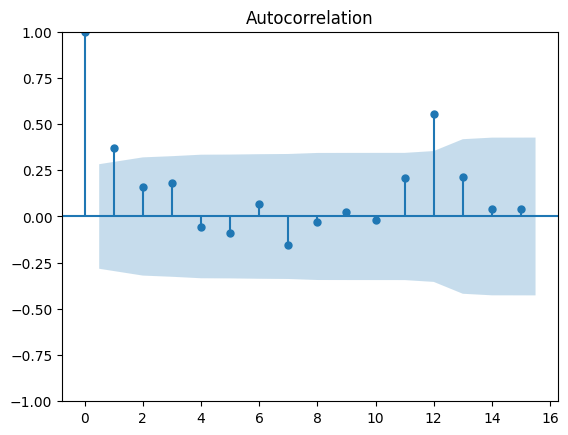

In [ ]:
plot_pacf(x=sales, lags=15)
plot_acf(x=sales, lags=15)
plt.show()

It appears that there is a correlation between an observation and its previous one, which suggests using one lagged value to predict an observation, and we should account for the lagged value before recalculating the autocorrelation and choose whether to include any error terms.
We notice that there is a correlation between an observation an the previous 12 lagged observations, and this corresponds to last year's observation which suggests seasonality in our series and building a model that takes into account this sesonality.

To build a time series model, we will call a method that uses different model on the time series, and finally chooses the model with the lowest AIC score

In [ ]:
model = pm.auto_arima(sales,
                      m=12,
                      seasonal=True,
                      d=None,
                      test='adf',
                      start_p=0, start_q=0,
                      max_p=12, max_q=12,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1085.632, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.34 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.66 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.08 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.45 sec
 ARIMA(2,1,0)(1,0,1

The model fitted used one differentiation term despite that we tested that the series was stationary, it also used two previous lagged values and one seasonal component which we noticed in the autocorrelation of an observation with the 12th lagged value